#Setup

In [0]:
import tensorflow as tf

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# 2. Download data set
file_ds2 = drive.CreateFile({'id': '1FIZsUj4I2Hb-HtKPGaANQ-KhiIihodMD'})
file_ds2.GetContentFile('dataset2.zip')
  
# !rm -rf dataset-master
!rm -rf dataset2-master  

# !unzip -q dataset.zip
!unzip -q dataset2.zip

     |████████████████████████████████| 993kB 6.4MB/s 


W0816 08:09:04.596005 140100967602048 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

#Show an original image

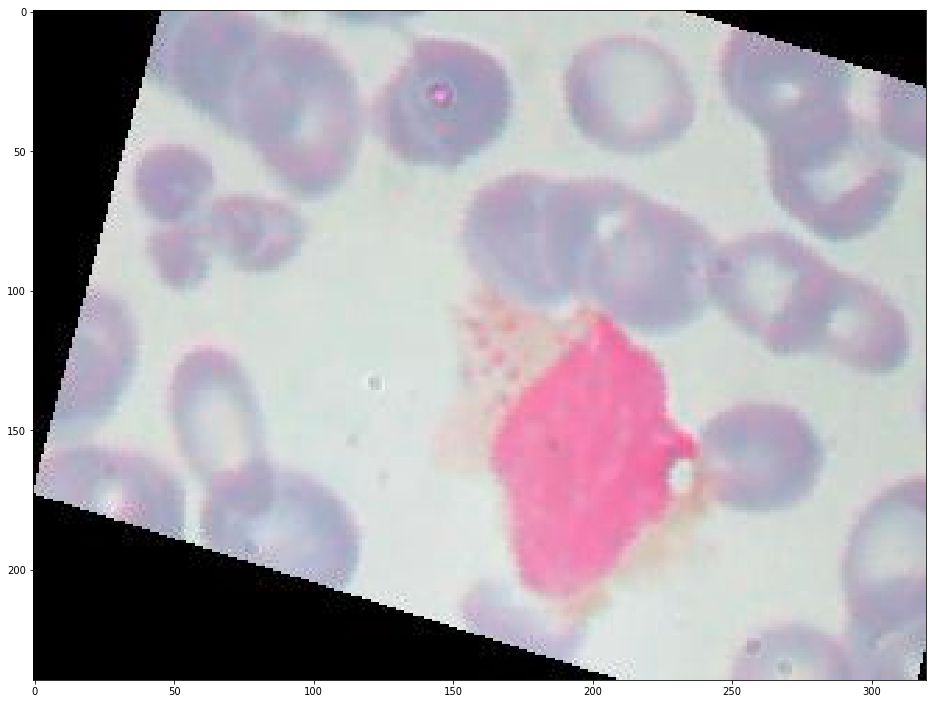

In [0]:
image = cv2.imread("dataset2-master/images/TRAIN/MONOCYTE/_0_5226.jpeg")
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()



#load data for images

In [0]:
labels = ["NEUTROPHIL",  
          "EOSINOPHIL",     
          "MONOCYTE",       
          "LYMPHOCYTE"]
img_rows,img_cols=60,80
input_shape = (img_rows, img_cols)

!pip install tqdm
from tqdm import tqdm
from PIL import Image
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
            elif wbc_type in ['MONOCYTE']:
                label = 3  
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
            else:
                label = 5
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = np.array(Image.fromarray(img_file).resize(input_shape))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data('dataset2-master/images/TRAIN/')
X_test, y_test = get_data('dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)

# normalize to 0 to 1
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

100%|██████████| 624/624 [00:00<00:00, 825.90it/s]
Using TensorFlow backend.


# build CNN model

In [0]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.Sequential()

# Flatten, dense, dropout layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(5, activation='softmax'))



W0816 08:09:57.452463 140100967602048 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# simple compile and fit

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_trainHot, epochs=30)

9957/9957 [==============================] - 3s 283us/sample - loss: 1.9033 - acc: 0.2436


#test prediction

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  NEUTROPHIL       0.00      0.00      0.00       624
  EOSINOPHIL       0.00      0.00      0.00       623
    MONOCYTE       0.25      1.00      0.40       620
  LYMPHOCYTE       0.00      0.00      0.00       620

    accuracy                           0.25      2487
   macro avg       0.06      0.25      0.10      2487
weighted avg       0.06      0.25      0.10      2487



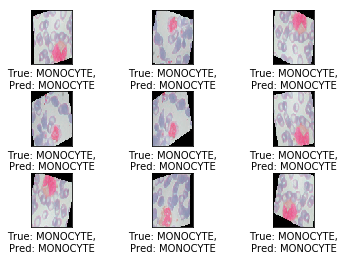

acc: 0.25


In [0]:
preds = model.predict(X_test)

cls_pred = np.argmax(preds, axis=1)
print(sklearn.metrics.classification_report(y_test, cls_pred, target_names=labels))

img_shape = input_shape

#show the images
import matplotlib.pyplot as plt

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(labels[cls_true[i]-1])
        else:
            xlabel = "True: {0},\nPred: {1}".format(labels[cls_true[i]-1],
                                                    labels[cls_pred[i]-1])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
plot_images(X_test[0:9], np.argmax(y_testHot[0:9], axis=1), cls_pred[0:9])

print("acc: %.02f" % sklearn.metrics.accuracy_score(y_test, cls_pred))

# Step 2

In [0]:
# Build CNN model
model_2 = tf.keras.models.Sequential()

model_2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(80, 60, 3))) 
model_2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')) 
model_2.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_2.add(tf.keras.layers.Dropout(0.25))

model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.5))
model_2.add(tf.keras.layers.Dense(5, activation='softmax'))


# convolutional layer
# pooling layer
# flatten layer
# dense/fully connected layer
# dropout layer


In [0]:
# Model compile and fit
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

datagen = tf.keras.preprocessing.image.ImageDataGenerator()
datagen.fit(X_train)
model_2.fit_generator(datagen.flow(X_train, y_trainHot, batch_size=32), epochs=30)

Epoch 1/30
312/312 [==============================] - 12s 38ms/step - loss: 1.5020 - acc: 0.2450
Epoch 2/30
312/312 [==============================] - 9s 28ms/step - loss: 1.3643 - acc: 0.3087
Epoch 3/30
312/312 [==============================] - 9s 27ms/step - loss: 1.3712 - acc: 0.2892
Epoch 4/30
312/312 [==============================] - 9s 27ms/step - loss: 1.3837 - acc: 0.2824
Epoch 5/30
312/312 [==============================] - 9s 28ms/step - loss: 1.3080 - acc: 0.3534
Epoch 6/30
312/312 [==============================] - 9s 27ms/step - loss: 1.1884 - acc: 0.4328
Epoch 7/30
312/312 [==============================] - 9s 27ms/step - loss: 1.0573 - acc: 0.5243
Epoch 8/30
312/312 [==============================] - 9s 27ms/step - loss: 0.9238 - acc: 0.5981
Epoch 9/30
312/312 [==============================] - 9s 27ms/step - loss: 0.8138 - acc: 0.6550
Epoch 10/30
312/312 [==============================] - 9s 27ms/step - loss: 0.7090 - acc: 0.7063
Epoch 11/30
312/312 [=================

              precision    recall  f1-score   support

  NEUTROPHIL       0.50      0.61      0.55       624
  EOSINOPHIL       0.59      0.57      0.58       623
    MONOCYTE       0.93      0.76      0.84       620
  LYMPHOCYTE       0.89      0.87      0.88       620

    accuracy                           0.70      2487
   macro avg       0.72      0.70      0.71      2487
weighted avg       0.72      0.70      0.71      2487



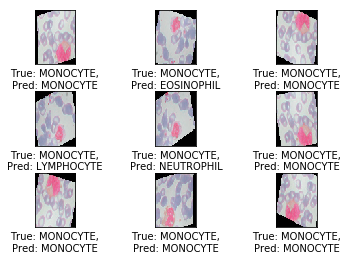

acc: 0.70


In [0]:
# Test prediction
preds = model_2.predict(X_test)

cls_pred = np.argmax(preds, axis=1)
print(sklearn.metrics.classification_report(y_test, cls_pred, target_names=labels))

img_shape = input_shape

#show the images
import matplotlib.pyplot as plt

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(labels[cls_true[i]-1])
        else:
            xlabel = "True: {0},\nPred: {1}".format(labels[cls_true[i]-1],
                                                    labels[cls_pred[i]-1])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
plot_images(X_test[0:9], np.argmax(y_testHot[0:9], axis=1), cls_pred[0:9])

print("acc: %.02f" % sklearn.metrics.accuracy_score(y_test, cls_pred))

# Step3

In [0]:
# Build CNN model
model_3 = tf.keras.models.Sequential()

model_3.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(80, 60, 3))) 
model_3.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')) 
model_3.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_3.add(tf.keras.layers.Dropout(0.25))

model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(128, activation='relu'))
model_3.add(tf.keras.layers.Dropout(0.5))
model_3.add(tf.keras.layers.Dense(5, activation='softmax'))

model_3.summary()

# convolutional layer
# pooling layer
# flatten layer
# dense/fully connected layer
# dropout layer


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 76, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 28, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 38, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 68096)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8716416   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [0]:
# Model compile and fit
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                   featurewise_center=False, 
                   samplewise_center=False, 
                   featurewise_std_normalization=False, 
                   samplewise_std_normalization=False, 
                   zca_whitening=False, 
                   zca_epsilon=1e-06, 
                   rotation_range=5, 
                   width_shift_range=0.3, 
                   height_shift_range=0.6, 
                   brightness_range=None, 
                   shear_range=0.0, 
                   zoom_range=0.0, 
                   channel_shift_range=0.0, 
                   fill_mode='nearest', 
                   cval=0.0, 
                   horizontal_flip=True, 
                   vertical_flip=False, 
                   rescale=None, 
                   preprocessing_function=None, 
                   data_format=None, 
                   validation_split=0.0, 
                   dtype=None)

datagen.fit(X_train)
model_3.fit_generator(datagen.flow(X_train, y_trainHot, batch_size=32), epochs=30)

Epoch 1/30
312/312 [==============================] - 20s 65ms/step - loss: 0.4856 - acc: 0.7843
Epoch 2/30
312/312 [==============================] - 20s 64ms/step - loss: 0.4808 - acc: 0.7881
Epoch 3/30
312/312 [==============================] - 20s 65ms/step - loss: 0.4596 - acc: 0.7921
Epoch 4/30
312/312 [==============================] - 20s 63ms/step - loss: 0.4712 - acc: 0.7890
Epoch 5/30
312/312 [==============================] - 20s 64ms/step - loss: 0.4563 - acc: 0.7986
Epoch 6/30
312/312 [==============================] - 20s 64ms/step - loss: 0.4611 - acc: 0.7924
Epoch 7/30
312/312 [==============================] - 20s 63ms/step - loss: 0.4646 - acc: 0.7912
Epoch 8/30
312/312 [==============================] - 20s 64ms/step - loss: 0.4741 - acc: 0.7872
Epoch 9/30
312/312 [==============================] - 20s 63ms/step - loss: 0.4426 - acc: 0.7978
Epoch 10/30
312/312 [==============================] - 20s 63ms/step - loss: 0.4637 - acc: 0.7945
Epoch 11/30
312/312 [========

              precision    recall  f1-score   support

  NEUTROPHIL       0.73      0.92      0.81       624
  EOSINOPHIL       0.92      0.88      0.90       623
    MONOCYTE       1.00      0.75      0.86       620
  LYMPHOCYTE       0.97      1.00      0.98       620

    accuracy                           0.89      2487
   macro avg       0.90      0.89      0.89      2487
weighted avg       0.90      0.89      0.89      2487



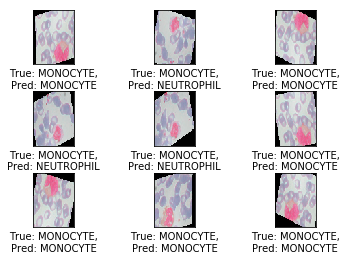

acc: 0.89


In [0]:
# Test prediction
preds = model_3.predict(X_test)

cls_pred = np.argmax(preds, axis=1)
print(sklearn.metrics.classification_report(y_test, cls_pred, target_names=labels))

img_shape = input_shape

#show the images
import matplotlib.pyplot as plt

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(labels[cls_true[i]-1])
        else:
            xlabel = "True: {0},\nPred: {1}".format(labels[cls_true[i]-1],
                                                    labels[cls_pred[i]-1])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
plot_images(X_test[0:9], np.argmax(y_testHot[0:9], axis=1), cls_pred[0:9])

print("acc: %.02f" % sklearn.metrics.accuracy_score(y_test, cls_pred))